In [2]:
import numpy as np
from numpy import linalg as la
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Load the MNIST data
mnist = fetch_openml('mnist_784', parser='auto')   # If there is an error, delete ", parser='auto'"
X = mnist.data / 255.0  # Scale the data to [0, 1]
y = mnist.target

## i. Truncated SVD of MNIST

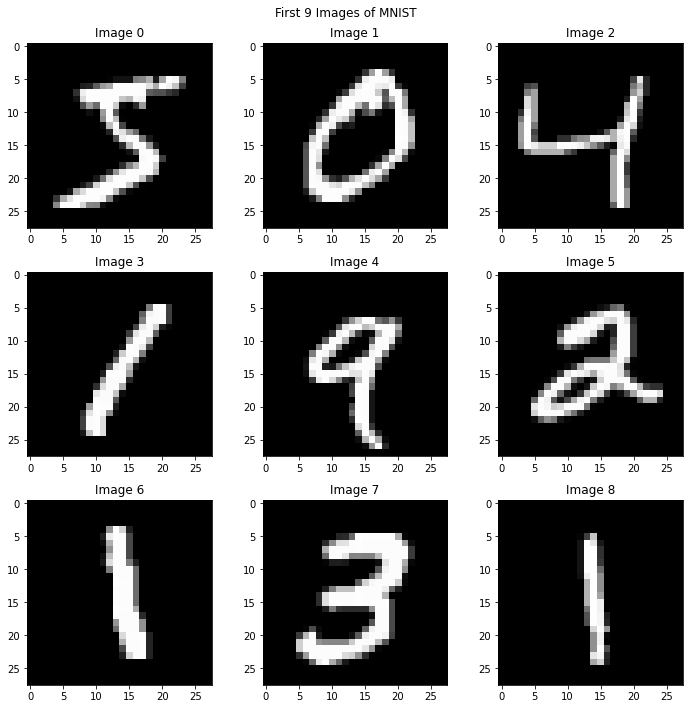

In [3]:
# Plot the first 9 images of MNIST in grayscale
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.array(X.T)[:, i].reshape(28,28), cmap='gray')
    plt.title('Image ' + str(i))
plt.suptitle('First 9 Images of MNIST')
plt.tight_layout()

In [3]:
# Compute the full SVD of MNIST
n_components = 784 # The maximum amount of components
svd = TruncatedSVD(n_components=n_components)  
X_svd = svd.fit_transform(X.T)

U = X_svd / svd.singular_values_
S = np.diag(svd.singular_values_)
VT = svd.components_
print("Dimension of U =", U.shape)
print("Dimension of VT =", VT.shape)

Dimension of U = (784, 784)
Dimension of VT = (784, 70000)


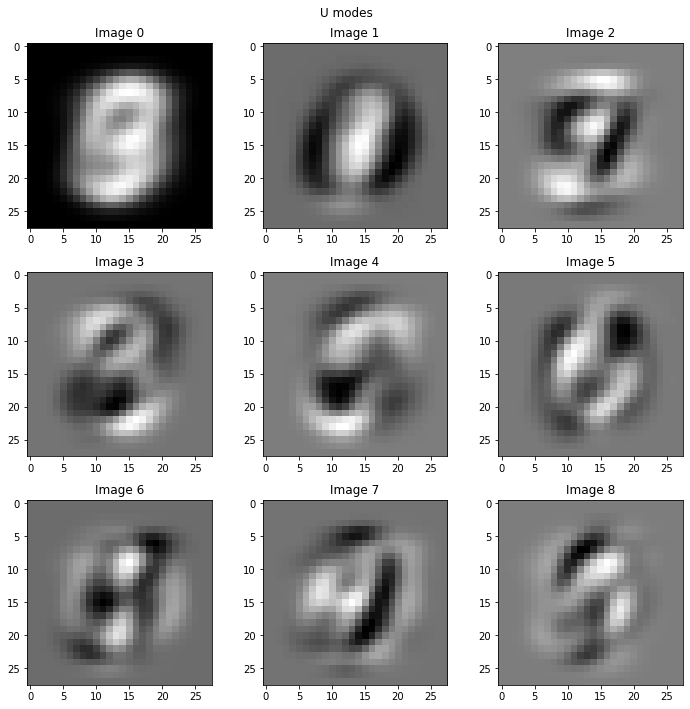

In [4]:
# Plot the first 9 U modes
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(U[:, i].reshape(28,28), cmap='gray')
    plt.title('Image ' + str(i))
plt.suptitle('U modes')
plt.tight_layout()

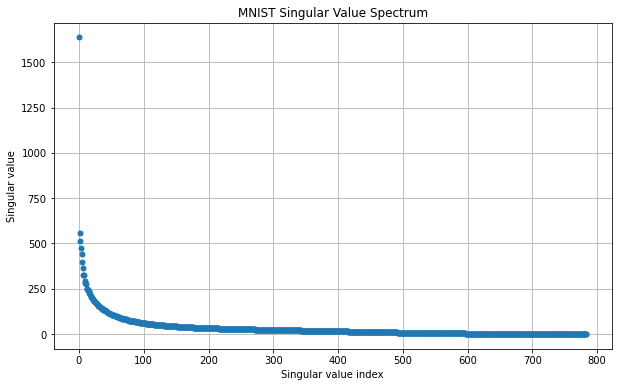

In [5]:
# Plot singular value spectrum
plt.figure(figsize=(10,6))
plt.plot(svd.singular_values_,'o', markersize=5)
plt.xlabel('Singular value index')
plt.ylabel('Singular value')
plt.title('MNIST Singular Value Spectrum')
plt.grid(True)
plt.show()

Number of modes necessary for good image reconstruction: 344


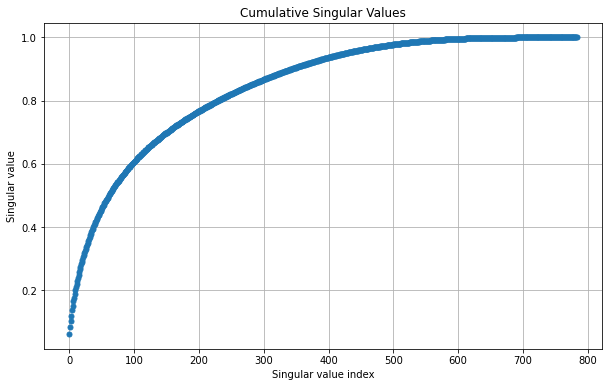

In [6]:
# # Find how many SVD modes describe at least 90% of the data

total_sum = np.sum(svd.singular_values_)
cumulative_sum = np.cumsum(svd.singular_values_)/total_sum   # Scaled to [0, 1]
plt.figure(figsize=(10,6))
plt.plot(cumulative_sum,'o', markersize=5)
plt.xlabel('Singular value index')
plt.ylabel('Singular value')
plt.title('Cumulative Singular Values')
num_modes = np.where(cumulative_sum >= 0.9)[0][0] + 1
print('Number of modes necessary for good image reconstruction:', num_modes)

plt.grid(True)
plt.show()

In [7]:
# Find the rank of the matrix X which is the max number of SVD modes for the best image reconstruction
la.matrix_rank(X.T)

713

In [8]:
# Compute the truncated SVD of MNIST
n_components = 344 # Number of modes necessary for good image reconstruction
svd = TruncatedSVD(n_components=n_components)  # Compute the first 'n_components' singular vectors and values
Xf_svd = svd.fit_transform(X.T)

Uf = Xf_svd / svd.singular_values_
Sf = np.diag(svd.singular_values_)
VfT = svd.components_

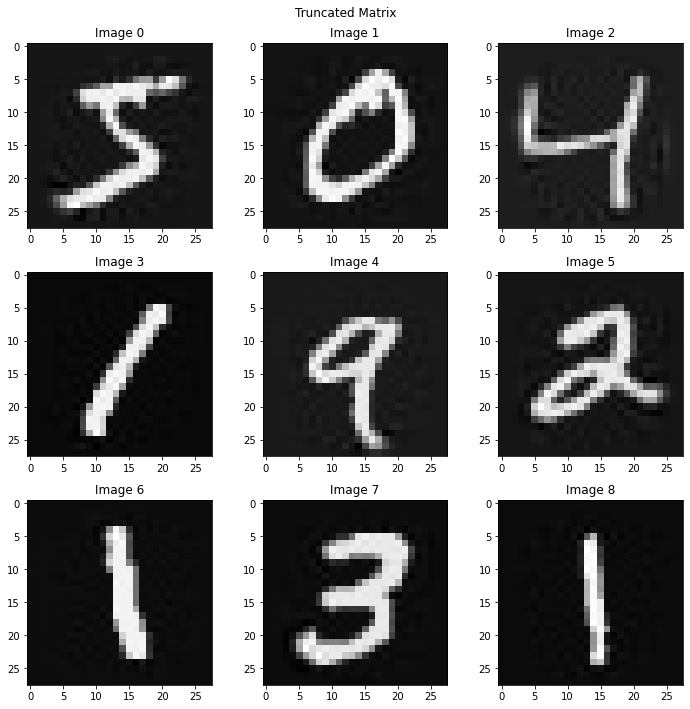

In [9]:
# Plot the first 9 images of the truncated matrix in grayscale
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.array(Uf@Sf@VfT)[:, i].reshape(28,28), cmap='gray')
    plt.title('Image ' + str(i))
plt.suptitle('Truncated Matrix')
plt.tight_layout()

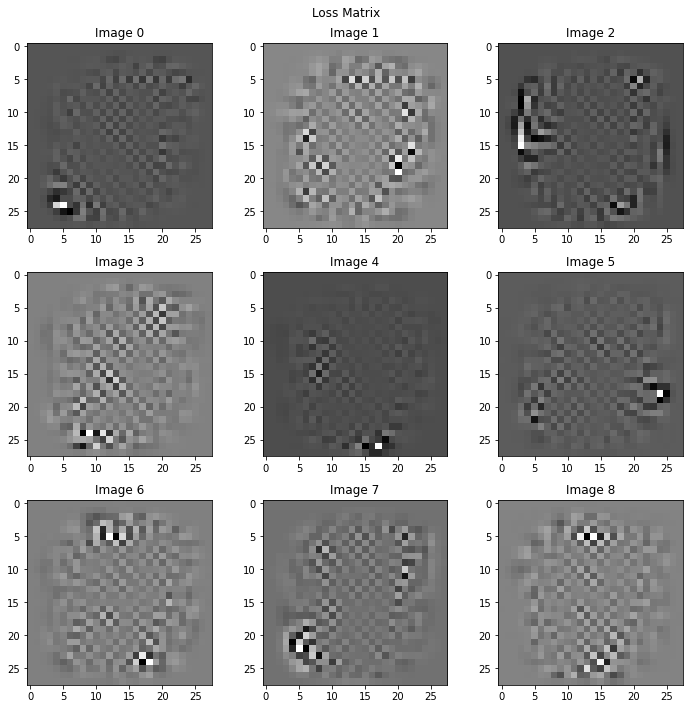

In [10]:
# Plot the first 9 images of the loss matrix in grayscale
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow((np.array(X.T)[:, i] - np.array(Uf@Sf@VfT)[:, i]).reshape(28,28), cmap='gray')
    plt.title('Image ' + str(i))
plt.suptitle('Loss Matrix')
plt.tight_layout()

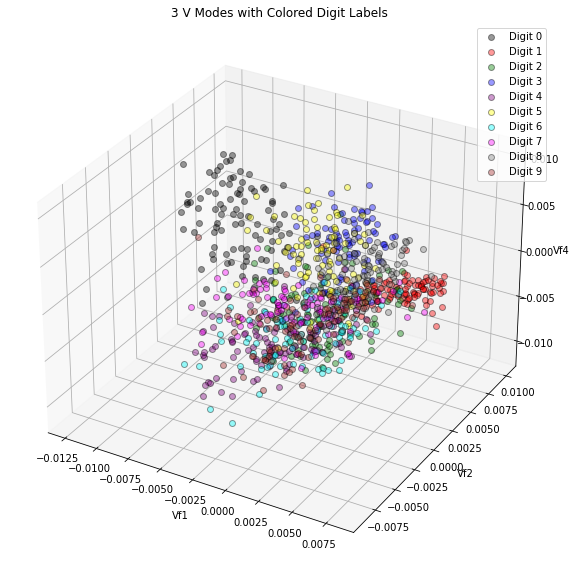

In [32]:
#Project three selected V-modes (columns) colored by their digit label onto a 3D plot.
# For example, columns 1, 2, and 4.

plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
colors = ['black','red','green','blue','purple','yellow','cyan','magenta','gray','brown']
for i in np.arange(10):
    idx = np.where(y == str(i))[0][0:99]
    c = colors[i]
    plt.plot(VfT.T[idx, 1],VfT.T[idx, 2],VfT.T[idx,4],'.',color=c,markeredgecolor='k', alpha=0.4,ms=12, label=('Digit '+str(i)))
ax.set_xlabel('Vf1')
ax.set_ylabel('Vf2')
ax.set_zlabel('Vf4')
plt.title('3 V Modes with Colored Digit Labels')
plt.legend()

## ii. Building a Linear Classifier

In [12]:
## Pick two digits: '0' and '1'
indexTo0 = np.where(y == '0')[0]
indexTo1 = np.where(y == '1')[0]
print("Number of rows for digit '0':", len(indexTo0))
print("Number of rows for digit '1':", len(indexTo1))
zeroOne = X.loc[np.concatenate((indexTo0, indexTo1))] 
start0 = 0
start1 = len(indexTo0)

Number of rows for digit '0': 6903
Number of rows for digit '1': 7877


In [13]:
# Compute the truncated SVD of the 0's and 1's of MNIST
n_components = 344 
svd = TruncatedSVD(n_components=n_components)  # Compute the first 'n_components' singular vectors and values
X_svd = svd.fit_transform(zeroOne.T)

U01 = X_svd / svd.singular_values_
S01 = np.diag(svd.singular_values_)
VT01 = svd.components_

xtrain2 shape: (120, 2)
test2 shape: (40, 2)
accuracy: 1.0


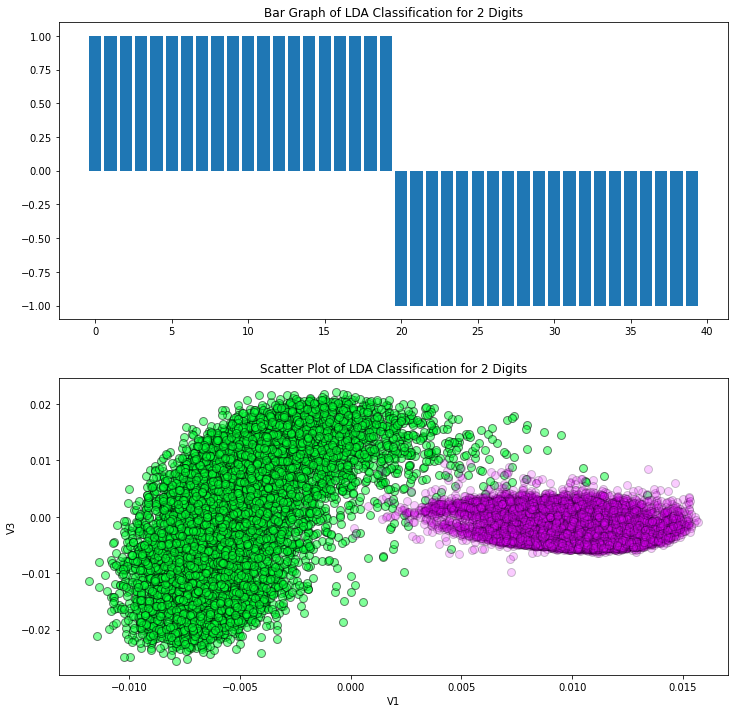

In [14]:
# Build a linear classifier (LDA) that can classify the two digits
plt.rcParams['figure.figsize'] = [12, 12]
featureCols=[1,3]
xtrain2 = np.concatenate((VT01.T[:60,featureCols],VT01.T[len(indexTo1):(len(indexTo1)+60),featureCols]))
label2 = np.repeat(np.array([1,-1]),60)  # label 1 for "0" and -1 for "1"
test2 = np.concatenate((VT01.T[60:80,featureCols],VT01.T[(len(indexTo1)+60):(len(indexTo1)+80),featureCols]))

print("xtrain2 shape:", xtrain2.shape)
print("test2 shape:", test2.shape)
lda = LinearDiscriminantAnalysis()
test_class = lda.fit(xtrain2, label2).predict(test2)
acc = (sum(1==test_class[range(20)])+sum(-1==test_class[range(20,40)]))/40
print('accuracy:', acc)
fig,axs = plt.subplots(2)
axs[0].bar(range(40),test_class)
axs[0].set_title('Bar Graph of LDA Classification for 2 Digits')

axs[1].plot(VT01.T[:start1,1],VT01.T[:start1,3],'ro',markerfacecolor=(0,1,0.2),markeredgecolor='k',ms=8,alpha=.5)
axs[1].plot(VT01.T[start1:,1],VT01.T[start1:,3],'bo',markerfacecolor=(0.9,0,1),markeredgecolor='k',ms=8,alpha=.2)
axs[1].set_xlabel('V1')
axs[1].set_ylabel('V3')
axs[1].set_title('Scatter Plot of LDA Classification for 2 Digits')
plt.show()

In [15]:
## Pick 3 digits: '0', '1',and '2'
indexTo0 = np.where(y == '0')[0]
indexTo1 = np.where(y == '1')[0]
indexTo2 = np.where(y == '2')[0]
print("Number of rows for digit '0':", len(indexTo0))
print("Number of rows for digit '1':", len(indexTo1))
print("Number of rows for digit '2':", len(indexTo2))
zeroOneTwo = X.loc[np.concatenate((indexTo0, indexTo1,indexTo2))] 


Number of rows for digit '0': 6903
Number of rows for digit '1': 7877
Number of rows for digit '2': 6990


In [16]:
# Compute the truncated SVD of 0's, 1's, and 2's of MNIST
n_components = 344
svd = TruncatedSVD(n_components=n_components)  # Compute the first 'n_components' singular vectors and values
X_svd = svd.fit_transform(zeroOneTwo.T)

U012 = X_svd / svd.singular_values_
S012 = np.diag(svd.singular_values_)
VT012 = svd.components_

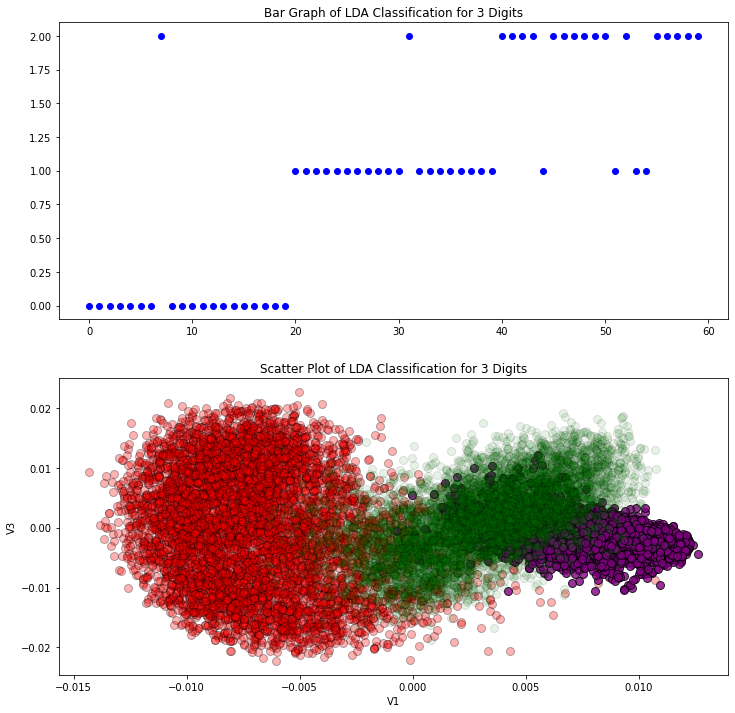

In [17]:
# Build a linear classifier to classify three digits
start0 = 0
start1 = len(indexTo0)
start2 = start1+len(indexTo1)

plt.rcParams['figure.figsize'] = [12, 12]
featureCols=[1,3,5]

trainRows=1000
xtrain3 = np.concatenate((VT012.T[:trainRows,np.array(featureCols)] 
                         ,VT012.T[start1:(start1+trainRows),np.array(featureCols)]
                         ,VT012.T[start2:(start2+trainRows),np.array(featureCols)]))
label3 = np.repeat(np.array([0,1,2]),trainRows)

test3 = np.concatenate((VT012.T[trainRows:trainRows+20,np.array(featureCols)] 
                         ,VT012.T[(start1+trainRows):(start1+trainRows+20),np.array(featureCols)]
                         ,VT012.T[(start2+trainRows):(start2+trainRows+20),np.array(featureCols)]))

lda = LinearDiscriminantAnalysis()
test_class = lda.fit(xtrain3, label3).predict(test3)

fig,axs = plt.subplots(2)
axs[0].plot(test_class,'bo')
axs[0].set_title('Bar Graph of LDA Classification for 3 Digits')

axs[1].plot(VT012.T[:(start1-1),1],VT012.T[:(start1-1),3],'ro',markerfacecolor='red',markeredgecolor='k',ms=8,alpha=.3)
axs[1].plot(VT012.T[start1:(start2-1),1],VT012.T[start1:(start2-1),3],'bo',markerfacecolor='purple',markeredgecolor='k',ms=8,alpha=.8)
axs[1].plot(VT012.T[start2:,1],VT012.T[start2:,3],'bo',markerfacecolor='green',markeredgecolor='k',ms=8,alpha=.1)
axs[1].set_xlabel('V1')
axs[1].set_ylabel('V3')
axs[1].set_title('Scatter Plot of LDA Classification for 3 Digits')
plt.show()

Mean accuracy of LDA: 85.3%


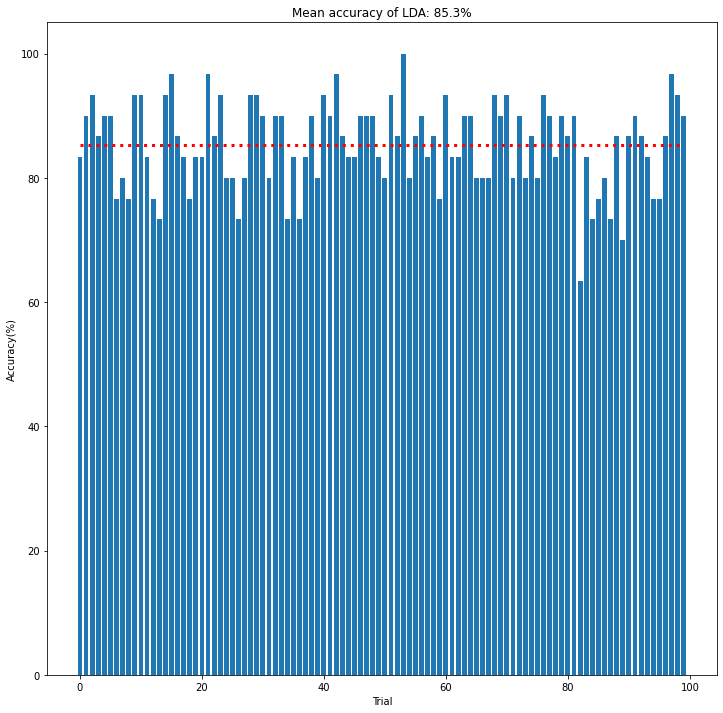

In [18]:
# Cross-validate the LDA model
from sklearn import svm
from sklearn.model_selection import cross_val_score
trials = 100
Clda = cross_val_score(lda, xtrain3, label3, cv=trials)

plt.figure()
ax = plt.axes()
plt.bar(range(trials),Clda*100)
plt.plot(range(trials),100*np.mean(Clda)*np.ones(trials),'r:',linewidth=3)
ax.set_ylabel('Accuracy(%)')
ax.set_xlabel('Trial')
title = "Mean accuracy of LDA: "+'%.1f' % (100*np.mean(Clda)) + "%"
ax.set_title(title)
print(title)

classLoss: 0.22466666666666635
Mean accuracy for SVM: 77.5%


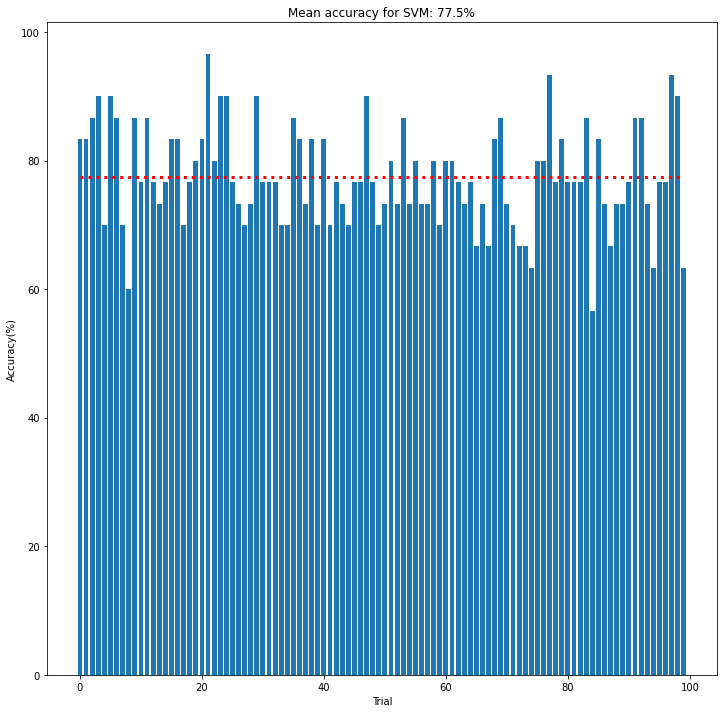

In [19]:
# SVM for 3 classes (3 different digits)
from sklearn import svm

Mdl = svm.SVC(kernel='rbf',gamma='auto').fit(xtrain3,label3)
test_labels = Mdl.predict(test3)
trials = 100
CMdl = cross_val_score(Mdl, xtrain3, label3, cv=trials) #cross-validate the model
classLoss = 1-np.mean(CMdl) # average error over all cross-validation iteration
print("classLoss:",classLoss)
plt.figure()
ax = plt.axes()
plt.bar(range(trials),CMdl*100)
plt.plot(range(trials),100*np.mean(CMdl)*np.ones(trials),'r:',linewidth=3)
ax.set_ylabel('Accuracy(%)')
ax.set_xlabel('Trial')
title = "Mean accuracy for SVM: "+ '%.1f' % (100*np.mean(CMdl)) + "%"
ax.set_title(title)
print(title)

Text(0.5, 1.0, 'Mean accuracy for decision tree model: 93.3%')

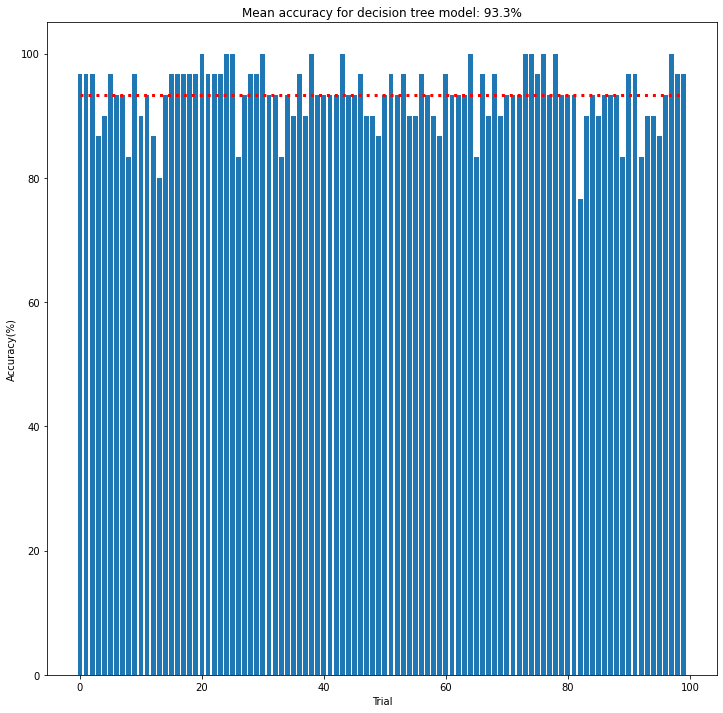

In [20]:
# Build a descicion tree model
from sklearn import tree, preprocessing

decision_tree = tree.DecisionTreeClassifier(max_depth=7).fit(xtrain3,label3)
test_labels = decision_tree.predict(test3)
trials = 100
CDT = cross_val_score(decision_tree, xtrain3, label3, cv=trials) # cross-validate the model

plt.figure()
ax = plt.axes()
plt.bar(range(trials),CDT*100)
plt.plot(range(trials),100*np.mean(CDT)*np.ones(trials),'r:',linewidth=3)
ax.set_ylabel('Accuracy(%)')
ax.set_xlabel('Trial')
title="Mean accuracy for decision tree model: " + '%.1f' % (100*np.mean(CDT)) +"%"
ax.set_title(title)

## iii. Classifying All Digit Pairs

Number of rows for digit  0 : 6903
Number of rows for digit  1 : 7877
accuracy: 0.975
Number of rows for digit  0 : 6903
Number of rows for digit  2 : 6990
accuracy: 0.95
Number of rows for digit  0 : 6903
Number of rows for digit  3 : 7141
accuracy: 0.975
Number of rows for digit  0 : 6903
Number of rows for digit  4 : 6824
accuracy: 0.9
Number of rows for digit  0 : 6903
Number of rows for digit  5 : 6313
accuracy: 0.6
Number of rows for digit  0 : 6903
Number of rows for digit  6 : 6876
accuracy: 0.825
Number of rows for digit  0 : 6903
Number of rows for digit  7 : 7293
accuracy: 0.95
Number of rows for digit  0 : 6903
Number of rows for digit  8 : 6825
accuracy: 0.975
Number of rows for digit  0 : 6903
Number of rows for digit  9 : 6958
accuracy: 0.95
Number of rows for digit  1 : 7877
Number of rows for digit  2 : 6990
accuracy: 0.825
Number of rows for digit  1 : 7877
Number of rows for digit  3 : 7141
accuracy: 0.975
Number of rows for digit  1 : 7877
Number of rows for digit  

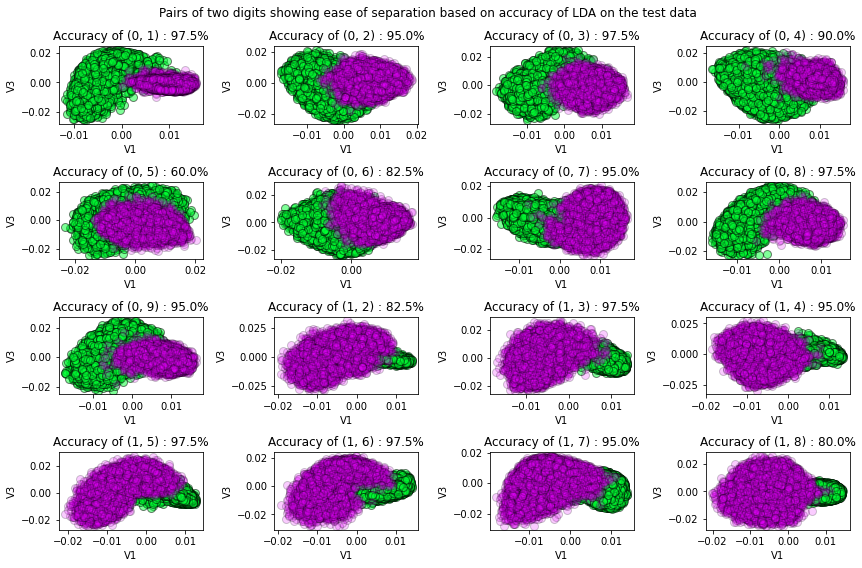

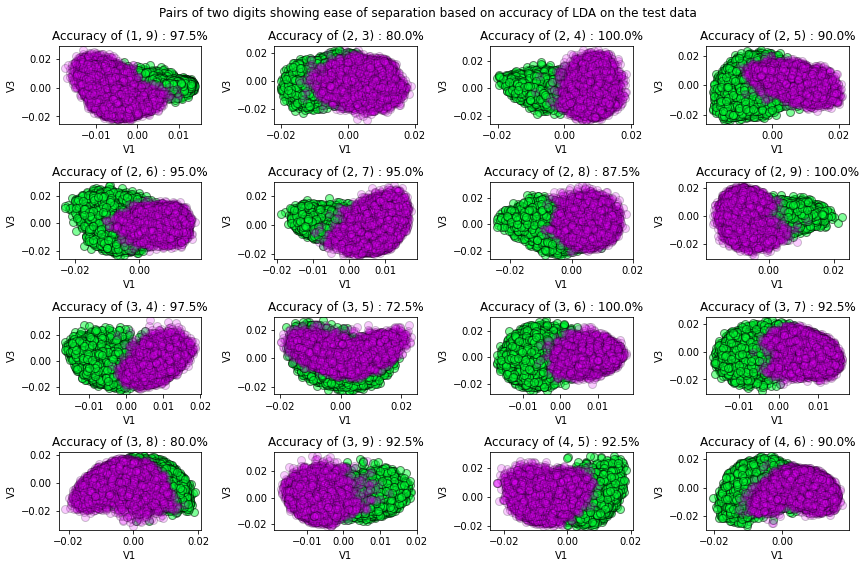

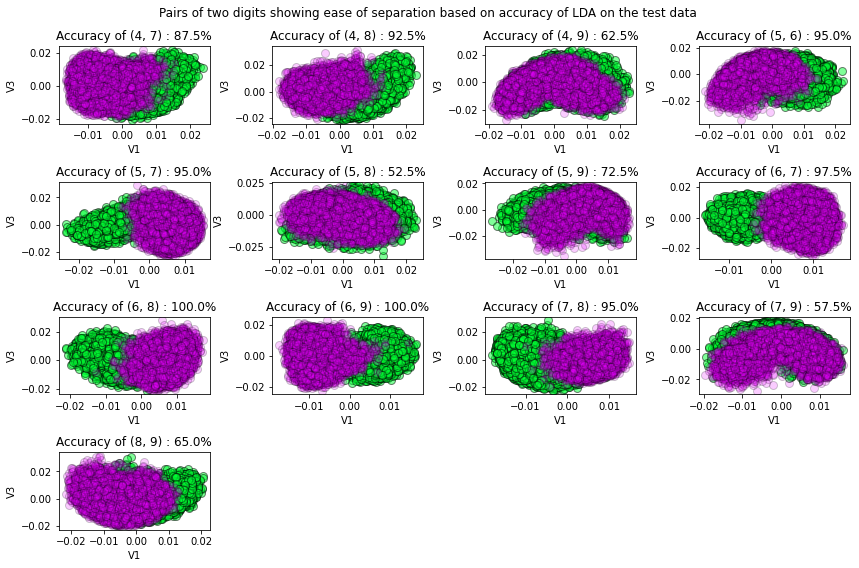

In [21]:
# Iterate for all combinations of pairs
j=0
import itertools
digits = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for subset in itertools.combinations(digits, 2):
    i1Rows = np.where(y == subset[0])[0]
    i2Rows = np.where(y == subset[1])[0]
    print("Number of rows for digit ", subset[0], ":", len(i1Rows))
    print("Number of rows for digit ", subset[1], ":", len(i2Rows))

    X2 = X.loc[np.concatenate((i1Rows, i2Rows))]

    i1Start = 0
    i2Start = len(i1Rows)

    # Compute the truncated SVD of MNIST
    n_components = 344 
    svd = TruncatedSVD(n_components=n_components)  # Compute the first 'n_components' singular vectors and values
    X2_svd = svd.fit_transform(X2.T)
    U2 = X2_svd / svd.singular_values_
    S2 = np.diag(svd.singular_values_)
    VT2 = svd.components_

    featureCols=[1,3]
    xtrain2 = np.concatenate((VT2.T[:60,featureCols],VT2.T[len(i1Rows):(len(i1Rows)+60),featureCols]))
    label2 = np.repeat(np.array([1,-1]),60)  # labeled 1 for "0" and -1 for "1"
    test2 = np.concatenate((VT2.T[60:80,featureCols],VT2.T[(len(i1Rows)+60):(len(i1Rows)+80),featureCols]))

    lda = LinearDiscriminantAnalysis()
    test_class = lda.fit(xtrain2, label2).predict(test2)  
    acc = (sum(1==test_class[range(20)])+sum(-1==test_class[range(20,40)]))/40
    print('accuracy:', acc)

    if((j % 16)== 0) : plt.figure(figsize=(12,8))      
    plt.subplot(4,4, (j % 16)+1)
    plt.plot(VT2.T[:i2Start,1],VT2.T[:i2Start,3],'ro',markerfacecolor=(0,1,0.2),markeredgecolor='k',ms=8,alpha=.5)
    plt.plot(VT2.T[i2Start:,1],VT2.T[i2Start:,3],'bo',markerfacecolor=(0.9,0,1),markeredgecolor='k',ms=8,alpha=.2)
    plt.xlabel('V1')
    plt.ylabel('V3')
    title="Accuracy of ("+ subset[0] + ', ' + subset[1] + ') : %.1f' % (100*acc) +"%"
    plt.title(title)
    j = j+1

    plt.suptitle('Pairs of two digits showing ease of separation based on accuracy of LDA on the test data')
    plt.tight_layout()

## iv. Classifying All Digits

In [22]:
# Re-order rows to prepare for splitting training data from testing data
X09 = X.loc[np.concatenate((np.where(y == '0')[0], np.where(y == '1')[0],np.where(y == '2')[0],np.where(y == '3')[0],np.where(y == '4')[0]
                             ,np.where(y == '5')[0],np.where(y == '6')[0],np.where(y == '7')[0],np.where(y == '8')[0],np.where(y == '9')[0]))] 

In [23]:
# Compute the truncated SVD of all digits in MNIST
n_components = 344
svd = TruncatedSVD(n_components=n_components)  # Compute the first 'n_components' singular vectors and values
X_svd = svd.fit_transform(X09.T)

U09 = X_svd / svd.singular_values_
S09 = np.diag(svd.singular_values_)
VT09 = svd.components_
print("Dimensions of VT09 =", VT09.shape)

Dimensions of VT09 = (344, 70000)


In [24]:
featureCols=list()
for i in range(10):
    featureCols.append(np.where(y == str(i))[0][0])
print(featureCols)
start0 = 0
start1 = len(np.where(y == '0')[0])
start2 = start1+len(np.where(y == '1')[0])
start3 = start2+len(np.where(y == '2')[0])
start4 = start3+len(np.where(y == '3')[0])
start5 = start4+len(np.where(y == '4')[0])
start6 = start5+len(np.where(y == '5')[0])
start7 = start6+len(np.where(y == '6')[0])
start8 = start7+len(np.where(y == '7')[0])
start9 = start8+len(np.where(y == '8')[0])
trainRows=1000
xtrain10 = np.concatenate((VT09.T[:trainRows,np.array(featureCols)] 
                         ,VT09.T[start1:(start1+trainRows),np.array(featureCols)]
                         ,VT09.T[start2:(start2+trainRows),np.array(featureCols)]
                         ,VT09.T[start3:(start3+trainRows),np.array(featureCols)]
                         ,VT09.T[start4:(start4+trainRows),np.array(featureCols)]
                         ,VT09.T[start5:(start5+trainRows),np.array(featureCols)]
                         ,VT09.T[start6:(start6+trainRows),np.array(featureCols)]
                         ,VT09.T[start7:(start7+trainRows),np.array(featureCols)]
                         ,VT09.T[start8:(start8+trainRows),np.array(featureCols)]
                         ,VT09.T[start9:(start9+trainRows),np.array(featureCols)]))
label10 = np.repeat(np.array(list(range(10))),trainRows)
print('label10:',label10)
print("xtrain10.shape:", xtrain10.shape)

[1, 3, 5, 7, 2, 0, 13, 15, 17, 4]
label10: [0 0 0 ... 9 9 9]
xtrain10.shape: (10000, 10)


classLoss: 0.22466666666666635


Text(0.5, 1.0, 'Mean accuracy for LDA: 75.2%')

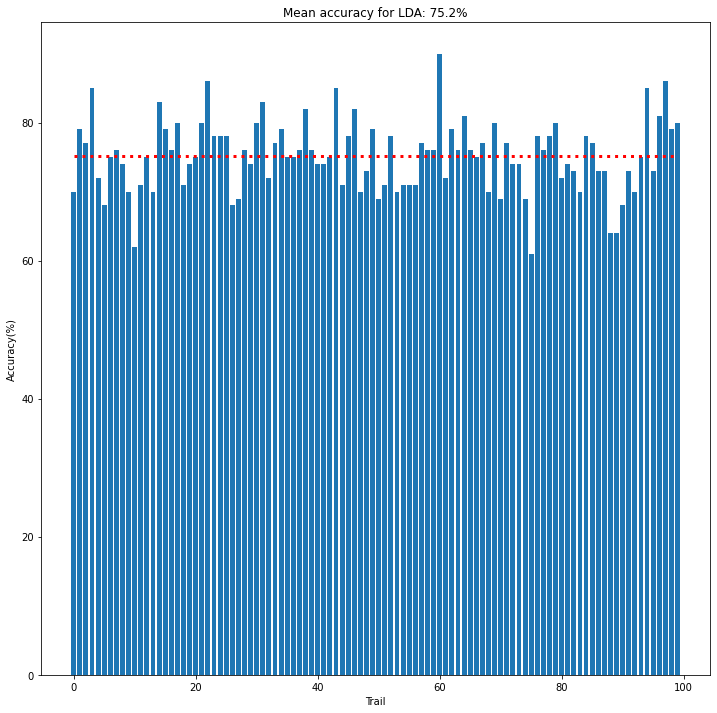

In [25]:
## LDA for classifying all 10 different digits
trials = 100
lda = LinearDiscriminantAnalysis()
CLda = cross_val_score(lda, xtrain10, label10, cv=trials) #cross-validate the model
classLoss = 1-np.mean(CMdl) # average error over all cross-validation iteration
print("classLoss:",classLoss)
plt.figure()
ax = plt.axes()
plt.bar(range(trials),CLda*100)
plt.plot(range(trials),100*np.mean(CLda)*np.ones(trials),'r:',linewidth=3)
ax.set_ylabel('Accuracy(%)')
ax.set_xlabel('Trail')
title="Mean accuracy for LDA: " + '%.1f' % (100*np.mean(CLda)) +"%"
ax.set_title(title)

classLoss: 0.3711


Text(0.5, 1.0, 'Mean accuracy for SVM: 62.9%')

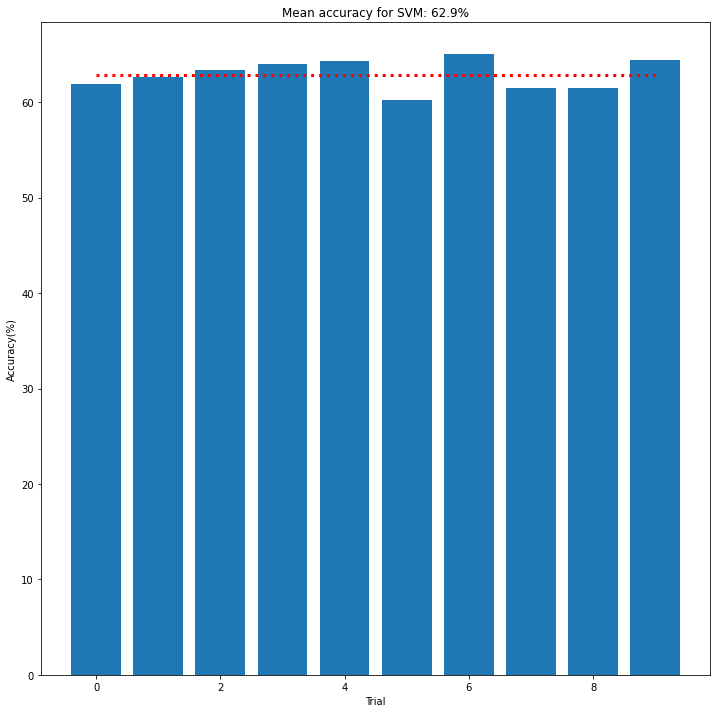

In [26]:
## SVM for classifying all 10 different digits
## WARNING: This can take a very long time for large xtrain10 and many trials...
Mdl = svm.SVC(kernel='rbf',gamma='auto').fit(xtrain10,label10)
trials = 10 
CMdl = cross_val_score(Mdl, xtrain10, label10, cv=trials) #cross-validate the model
classLoss = 1-np.mean(CMdl) # average error over all cross-validation iteration
print("classLoss:",classLoss)
plt.figure()
ax = plt.axes()
plt.bar(range(trials),CMdl*100)
plt.plot(range(trials),100*np.mean(CMdl)*np.ones(trials),'r:',linewidth=3)
ax.set_ylabel('Accuracy(%)')
ax.set_xlabel('Trial')
title="Mean accuracy for SVM: " + '%.1f' % (100*np.mean(CMdl)) +"%"
ax.set_title(title)

Text(0.5, 1.0, 'Mean accuracy for decision tree: 73.3%')

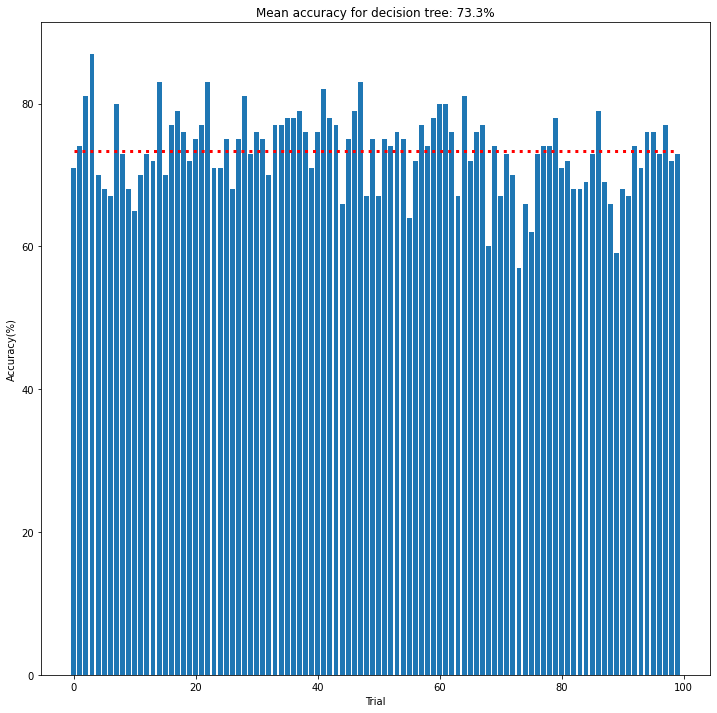

In [31]:
## Decision tree for classifying all 10 different digits
decision_tree = tree.DecisionTreeClassifier(max_depth=10).fit(xtrain10,label10)
trials = 100
CDT = cross_val_score(decision_tree, xtrain10, label10, cv=trials) #cross-validate the model

plt.figure()
ax = plt.axes()
plt.bar(range(trials),CDT*100)
plt.plot(range(trials),100*np.mean(CDT)*np.ones(trials),'r:',linewidth=3)
ax.set_ylabel('Accuracy(%)')
ax.set_xlabel('Trial')
title="Mean accuracy for decision tree: " + '%.1f' % (100*np.mean(CDT)) +"%"
ax.set_title(title)

## v. Comparing Classifier Models

In [28]:
# Hardest pair: (5, 8)
i1=5
i1Rows = np.where(y == str(i1))[0]
i2=8
i2Rows = np.where(y == str(i2))[0]
X2 = X.loc[np.concatenate((i1Rows, i2Rows))] 
i1Start = 0
i2Start = len(i1Rows)
print("---------------\nHardest pair (",i1,",", i2,")")
print("X2.shape:", X2.shape)
# Compute the truncated SVD of MNIST
n_components = 344 # 
svd = TruncatedSVD(n_components=n_components)  # Compute the first 'n_components' singular vectors and values
X2_svd = svd.fit_transform(X2.T)

U2 = X2_svd / svd.singular_values_
S2 = np.diag(svd.singular_values_)
VT2 = svd.components_
print("VT2.shape:", VT2.shape)
featureCols=[1,3]
xtrain2 = np.concatenate((VT2.T[:60,featureCols],VT2.T[len(indexTo1):(len(indexTo1)+60),featureCols]))
label2 = np.repeat(np.array([1,-1]),60)  # labeled 1 for "5" and -1 for "8"
test2 = np.concatenate((VT2.T[60:80,featureCols],VT2.T[(len(indexTo1)+60):(len(indexTo1)+80),featureCols]))
print("xtrain2.shape:", xtrain2.shape)
print("test2.shape:", test2.shape)
# LDA
lda = LinearDiscriminantAnalysis()
test_class = lda.fit(xtrain2, label2).predict(test2)  
accLDA = (sum(1==test_class[range(20)])+sum(-1==test_class[range(20,40)]))/40

# SVM
Mdl = svm.SVC(kernel='rbf',gamma='auto').fit(xtrain2,label2)
test_class = decision_tree.fit(xtrain2, label2).predict(test2)
accSVM = (sum(1==test_class[range(20)])+sum(-1==test_class[range(20,40)]))/40

## DecisionTree
decision_tree = tree.DecisionTreeClassifier(max_depth=5).fit(xtrain2,label2)
test_class = decision_tree.fit(xtrain2, label2).predict(test2)
accDT = (sum(1==test_class[range(20)])+sum(-1==test_class[range(20,40)]))/40
print("---------------\n")
print('accuracy of LDA:', '%.1f' % (100*accLDA) +"%")
print('accuracy of SVM:', '%.1f' % (100*accSVM) +"%") 
print('accuracy of DecisionTree:', '%.1f' % (100*accDT) +"%")


---------------
Hardest pair ( 5 , 8 )
X2.shape: (13138, 784)
VT2.shape: (344, 13138)
xtrain2.shape: (120, 2)
test2.shape: (40, 2)
---------------

accuracy of LDA: 40.0%
accuracy of SVM: 72.5%
accuracy of DecisionTree: 67.5%


In [29]:
# Easiest pair: (6, 9)
i1=6
i1Rows = np.where(y == str(i1))[0]
i2=9
i2Rows = np.where(y == str(i2))[0]
X2 = X.loc[np.concatenate((i1Rows, i2Rows))] 
i1Start = 0
i2Start = len(i1Rows)
print("---------------\nEasiest pair (",i1,",", i2,")")
print("X2.shape:", X2.shape)
# Compute the truncated SVD of digits 6 and 9 in MNIST
n_components = 344 
svd = TruncatedSVD(n_components=n_components)  # Compute the first 'n_components' singular vectors and values
X2_svd = svd.fit_transform(X2.T)

U2 = X2_svd / svd.singular_values_
S2 = np.diag(svd.singular_values_)
VT2 = svd.components_
print("VT2.shape:", VT2.shape)
featureCols=[1,3]
xtrain2 = np.concatenate((VT2.T[:60,featureCols],VT2.T[len(indexTo1):(len(indexTo1)+60),featureCols]))
label2 = np.repeat(np.array([1,-1]),60)  # labeled 1 for "6" and -1 for "9"
test2 = np.concatenate((VT2.T[60:80,featureCols],VT2.T[(len(indexTo1)+60):(len(indexTo1)+80),featureCols]))
print("xtrain2.shape:", xtrain2.shape)
print("test2.shape:", test2.shape)
# LDA
lda = LinearDiscriminantAnalysis()
test_class = lda.fit(xtrain2, label2).predict(test2)  
accLDA = (sum(1==test_class[range(20)])+sum(-1==test_class[range(20,40)]))/40

# SVM
Mdl = svm.SVC(kernel='rbf',gamma='auto').fit(xtrain2,label2)
test_class = decision_tree.fit(xtrain2, label2).predict(test2)
accSVM = (sum(1==test_class[range(20)])+sum(-1==test_class[range(20,40)]))/40

## DecisionTree
decision_tree = tree.DecisionTreeClassifier(max_depth=5).fit(xtrain2,label2)
test_class = decision_tree.fit(xtrain2, label2).predict(test2)
accDT = (sum(1==test_class[range(20)])+sum(-1==test_class[range(20,40)]))/40
print("---------------\n")
print('accuracy of LDA:', '%.1f' % (100*accLDA) +"%")
print('accuracy of SVM:', '%.1f' % (100*accSVM) +"%") 
print('accuracy of DecisionTree:', '%.1f' % (100*accDT) +"%")


---------------
Easiest pair ( 6 , 9 )
X2.shape: (13834, 784)
VT2.shape: (344, 13834)
xtrain2.shape: (120, 2)
test2.shape: (40, 2)
---------------

accuracy of LDA: 100.0%
accuracy of SVM: 100.0%
accuracy of DecisionTree: 100.0%
